# Transfer Learning Using Inception-v3

In [8]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Image Examples

In [4]:
base_dir = 'Top15data'
train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training "228:Skirt" pictures
train_skirt_dir = os.path.join(train_dir, '228')

# Directory with our training "137:Sandals" pictures
train_sandal_dir = os.path.join(train_dir, '137')

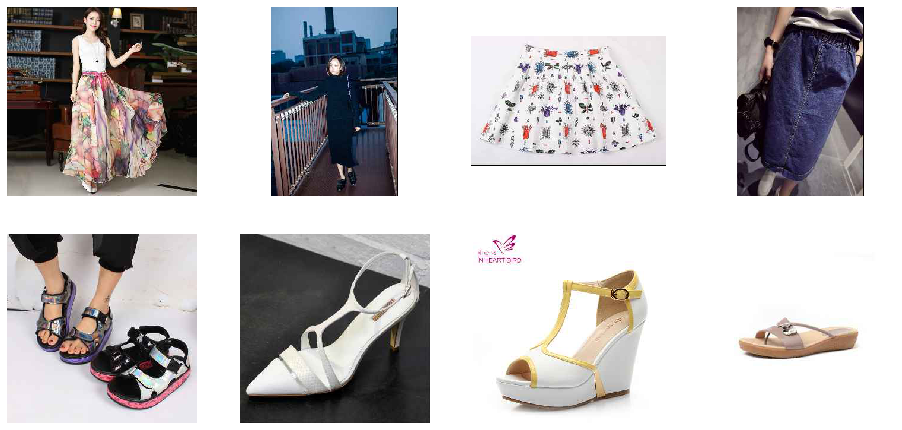

In [19]:
# Set up matplotlib fig, and size it to fit 4x4 pics
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 25
train_skirt_fnames = os.listdir( train_skirt_dir )
train_sandal_fnames = os.listdir( train_sandal_dir )

next_skirt_pix = [os.path.join(train_skirt_dir, fname) 
                for fname in train_skirt_fnames[ pic_index-4:pic_index]]

next_sandal_pix = [os.path.join(train_sandal_dir, fname) 
                for fname in train_sandal_fnames[ pic_index-4:pic_index]]

for i, img_path in enumerate(next_skirt_pix+next_sandal_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Pretrained model: all layers

Use all the layers in the model except for the last fully connected layer.

In [20]:
pre_trained_model = InceptionV3(input_shape = (128, 128, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
87916544/87910968 [==============================] - 27s 0us/step


Make all the layers non trainable now. We can retrain some of the lower layers to increase performance, but this may lead to overfitting.

In [21]:
for layer in pre_trained_model.layers:
    layer.trainable = False

#### Define a Callback class that stops training once accuracy reaches 95%

In [23]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.959):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [24]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a fully connected layer with 128 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final softmax layer for multi-classification
x = layers.Dense(15, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

#### Flow images in batches of 32 using train_datagen and val_datagen

In [28]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 32,
                                                    class_mode = 'categorical', 
                                                    target_size = (128, 128))     

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = val_datagen.flow_from_directory( validation_dir,
                                                        batch_size  = 32,
                                                        class_mode  = 'categorical', 
                                                        target_size = (128, 128))

Found 60646 images belonging to 15 classes.
Found 6738 images belonging to 15 classes.


In [31]:
# seems like the pretrained model doesn't work well with decreasing val_acc
callbacks = myCallback()
history = model.fit_generator(train_generator,
                              validation_data = validation_generator,
                              epochs = 50,
                              verbose = 1)

Epoch 1/50
1896/1896 [==============================] - 5193s 3s/step - loss: 2.2106 - acc: 0.2902 - val_loss: 2.0724 - val_acc: 0.4012
Epoch 2/50
1896/1896 [==============================] - 5475s 3s/step - loss: 2.1611 - acc: 0.3038 - val_loss: 2.3608 - val_acc: 0.3808
Epoch 3/50
1896/1896 [==============================] - 4718s 2s/step - loss: 2.1434 - acc: 0.3103 - val_loss: 2.4711 - val_acc: 0.3964
Epoch 4/50
 371/1896 [====>.........................] - ETA: 1:00:19 - loss: 2.1318 - acc: 0.3178

KeyboardInterrupt: 

### Plot Accuracy and Loss

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Do not use all the layers in the pretrained model

In [32]:
#Only use layers including and above 'mixed7'
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 768)


In [33]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)  
# Add a fully connected layer with 128 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x) 
# Add a final sigmoid layer for classification
x = layers.Dense(15, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [34]:
# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 32,
                                                    class_mode = 'categorical', 
                                                    target_size = (128, 128))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 32,
                                                          class_mode  = 'categorical', 
                                                          target_size = (128, 128))

callbacks = myCallback()
history = model.fit_generator(train_generator,
                              validation_data = validation_generator,
                              epochs = 50,
                              verbose = 1,
                              )

Found 60646 images belonging to 15 classes.
Found 6738 images belonging to 15 classes.
Epoch 1/50
1896/1896 [==============================] - 4751s 3s/step - loss: 1.9067 - acc: 0.3796 - val_loss: 2.2569 - val_acc: 0.5022
Epoch 2/50
1896/1896 [==============================] - 3870s 2s/step - loss: 1.7132 - acc: 0.4370 - val_loss: 2.7322 - val_acc: 0.4973
Epoch 3/50
1896/1896 [==============================] - 3253s 2s/step - loss: 1.6617 - acc: 0.4537 - val_loss: 3.0959 - val_acc: 0.5036
Epoch 4/50
1896/1896 [==============================] - 3240s 2s/step - loss: 1.6238 - acc: 0.4687 - val_loss: 3.6998 - val_acc: 0.5184
Epoch 5/50
1896/1896 [==============================] - 3221s 2s/step - loss: 1.6106 - acc: 0.4738 - val_loss: 4.4597 - val_acc: 0.5157
Epoch 6/50
1896/1896 [==============================] - 3176s 2s/step - loss: 1.5992 - acc: 0.4785 - val_loss: 5.4435 - val_acc: 0.5187
Epoch 7/50
1896/1896 [==============================] - 3173s 2s/step - loss: 1.5841 - acc: 0.487

In [50]:
# Save Model for future Predictions
model.save('Inceptionv3_model.h5')

## Plot accuracy and loss

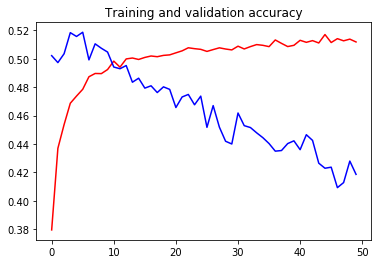

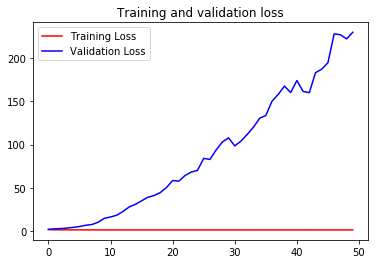

In [60]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()